In [2]:
import scoring

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from matplotlib import pyplot as plt
# %matplotlib inline
# from xgboost import XGBClassifier
import catboost

In [3]:
path = '../data/'

### Загрузка выборка + advanced baseline

In [4]:
%%time

df_train = pd.read_csv(path+'advanced_baseline_train.csv')
df_test  = pd.read_csv(path+'advanced_baseline_test.csv')

CPU times: user 1min 21s, sys: 6.17 s, total: 1min 27s
Wall time: 1min 27s


In [ ]:
df_test_private

In [5]:
if "Unnamed: 0" in df_train.columns:
    print('df_train contain Unnamed: 0')
    del df_train['Unnamed: 0']

df_train contain Unnamed: 0


### 6 базовых признаков

In [17]:
from functions_050218_ import get_dataframe_pair_diff_ncl, get_mean_count_points, get_len_div_dt

def calculate_angle(df):
    """
        params:
            df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
        return
            np.array
    """
    x1 = (df['MatchedHit_X[1]'] - df['MatchedHit_X[0]'],\
          df['MatchedHit_Y[1]'] - df['MatchedHit_Y[0]'],\
          df['MatchedHit_Z[1]'] - df['MatchedHit_Z[0]'])

    x2 = (df['MatchedHit_X[2]'] - df['MatchedHit_X[1]'],\
          df['MatchedHit_Y[2]'] - df['MatchedHit_Y[1]'],\
          df['MatchedHit_Z[2]'] - df['MatchedHit_Z[1]'])

    scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
    scalar11 = np.sum([i**2 for i in x1], axis = 0)
    scalar22 = np.sum([i**2 for i in x2], axis = 0)

    return ['angle'], [np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi]

def calculate_angle_ind(df, start_ind=1):
    """ 
        params: 
            df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
        return 
            np.array
    """
    i0 = (start_ind     ) % 3
    i1 = (start_ind + 1 ) % 3
    i2 = (start_ind + 2 ) % 3
    
    x1 = (df['MatchedHit_X[%i]' % i1] - df['MatchedHit_X[%i]' % i0],\
          df['MatchedHit_Y[%i]' % i1] - df['MatchedHit_Y[%i]' % i0],\
          df['MatchedHit_Z[%i]' % i1] - df['MatchedHit_Z[%i]' % i0])

    x2 = (df['MatchedHit_X[%i]' % i2] - df['MatchedHit_X[%i]' % i1],\
          df['MatchedHit_Y[%i]' % i2] - df['MatchedHit_Y[%i]' % i1],\
          df['MatchedHit_Z[%i]' % i2] - df['MatchedHit_Z[%i]' % i1])

    scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
    scalar11 = np.sum([i**2 for i in x1], axis = 0)
    scalar22 = np.sum([i**2 for i in x2], axis = 0)

    return  ['angle%d'%start_ind], [np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi]

def calculate_angle_0(data):
    return calculate_angle_ind(data, start_ind=0)

def calculate_angle_1(data):
    return calculate_angle_ind(data, start_ind=1)

def calculate_angle_2(data):
    return calculate_angle_ind(data, start_ind=2)

def get_column_lengths_trajectory(data):
    """
      Длинна траектории, чтобы это не значило
    """
    lengths = np.ones(len(data)) * 4
    for i in range(3, -1, -1):
        indices = np.where(data['MatchedHit_Z[{}]'.format(i)] < -9800)[0]
        lengths[indices] = i
    return ['traj_len'], [lengths]


def calc_diff_btw_trajectory_and_extr(data):
    diff_columns = {}
    res = np.zeros(len(data))
    for i in range(4):
        diff_columns[i] = {}
        for l in ['X', 'Y']:
            diff_columns[i][l] = (data["MatchedHit_%s[%i]"%(l, i)] - data["Lextra_%s[%i]"%(l, i)])**2
        res += np.sqrt(diff_columns[i]['X'] + diff_columns[i]['Y'])
    return ['deff_exp_ext'], [res]

# 3 колонки
def get_pair_diff_ncl(data):
    names = ['diff_ncl_0_1', 'diff_ncl_1_2', 'diff_ncl_2_3']
    serieses = []
    for i in range(3):
        diff = data['ncl[{}]'.format(i+1)] - data['ncl[{}]'.format(i)]
        serieses.append(diff)
    return names, serieses


# 7 колонок
def get_mean_count_points(data):
    prod_columns = ['mean_count_p_0', 'mean_count_p_1', 'mean_count_p_2', 'mean_count_p_3']
    diff_columns = ['diff_c_p_0_1', 'diff_c_p_1_2', 'diff_c_p_2_3']
    serieses = []
    for i in range(4):
        prod = data['ncl[{}]'.format(i)] * data['avg_cs[{}]'.format(i)]
        indices = np.where(data['MatchedHit_Z[{}]'.format(i)] < -9800)[0]
        prod.iloc[indices] = 0
        serieses.append(prod)

    for i in range(3):
        diff = serieses[i+1] - serieses[i]
        serieses.append(diff)

    return prod_columns + diff_columns, serieses
# get_mean_count_points(df_train_part)  # for debug

# 4 колонки
def get_len_div_dt(data):
    # in case someone wants to recalculate MEANS
    # MEANS_MH_Z = [train_data['MatchedHit_Z[{}]'.format(i)].mean() for i in range(4)]
    MEANS_MH_Z = [15261.270799160593, 16467.120796929295, 17203.93227585082, 18349.625745344583]

    names = []
    serieses = []
    for i in range(4):
        name = 'len_div_dt_[{}]'.format(i)
        names.append(name)
#         print(type(data[['MatchedHit_Z[{}]'.format(i)]].values))
#         print(data[['MatchedHit_Z[{}]'.format(i)]].values[:,0])
        div = None
#         print(data['MatchedHit_T[{}]'.format(i)].values.shape)
        div = (data[['MatchedHit_Z[{}]'.format(i)]].values[:,0] - MEANS_MH_Z[i]) / data['MatchedHit_T[{}]'.format(i)].values
        serieses.append(pd.Series(div))
    return names, serieses

# get_len_div_dt(df_train_part)  # for debug

In [21]:
from sklearn.base import TransformerMixin, ClassifierMixin
class FeatureTransformer(TransformerMixin):
    SIMPLE_FEATURES = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]',
                       'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
                       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
                       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
                       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
                       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
                       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
                       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
                       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
                       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
                       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
                       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
                       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
                       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
                       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]',
                       'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]',
                       'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]', 'Mextra_DY2[0]',
                       'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]', 'FOI_hits_N', 'PT', 'P',
                       'weight'] + ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
                                    '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

    CREATE_NEW_FEATURES = True

    def create_new_features(self, data):
        features_old = list(data.keys())
        functions = [calculate_angle_0,
                     calculate_angle_1,
                     calculate_angle_2,
                     get_column_lengths_trajectory,
                     calc_diff_btw_trajectory_and_extr
                     
#             calculate_angle,
#             calc_diff_btw_trajectory_and_extr,
#             get_len_div_dt, # MemoryError
#             get_mean_count_points,
#             get_pair_diff_ncl
        ]
        
        functions_many = [get_dataframe_pair_diff_ncl, 
                          get_mean_count_points
#                           get_len_div_dt
                         ]
        
        functions = [calculate_angle,
                     calculate_angle_0,
                     calculate_angle_1,
                     calculate_angle_2,
                     get_column_lengths_trajectory,
                     calc_diff_btw_trajectory_and_extr,
                     get_pair_diff_ncl,
                     get_mean_count_points,
                     get_len_div_dt]
        
#         for funct in functions:
#             data = funct(data)
#             print(funct, data.keys())
            
        for funct in functions:
            print(funct)
            names, rstls = funct(data)
            for name, rslt in zip(names, rstls):
                data[name] = rslt.copy()
                
        new_features = list(set(list(data.keys()))-set(features_old))
        print("new_features:"+', '.join(new_features))
        if self.SIMPLE_FEATURES is not None:
            self.SIMPLE_FEATURES.extend(new_features)
        return data

    def base_transform(self, data, create_new_features):
        if create_new_features:
            data = self.create_new_features(data)

        return data[self.SIMPLE_FEATURES]

    def transform(self, data, y=None):
        if self.CREATE_NEW_FEATURES:
            data = self.create_new_features(data)

        features = self.SIMPLE_FEATURES.copy()
        features.remove('weight')
        return data[features]

#   def fit_transform(self, X, y=None, **fit_params):
    def fit_transform(self, data, y=None, simple_feature_is_none = True, **fit_params):
        if simple_feature_is_none:
            self.SIMPLE_FEATURES = None
            
        if self.CREATE_NEW_FEATURES:
            data = self.create_new_features(data)
        
        if self.SIMPLE_FEATURES is None:
            return data
        
        return data[self.SIMPLE_FEATURES]

transformer = FeatureTransformer()

In [22]:
class ModelClass(ClassifierMixin):
    def __init__(self, estimator=None, features = None):
        if estimator is not None:
            self.estimator = estimator
        else:
            self.estimator = catboost.CatBoostClassifier(iterations=550, max_depth=8, thread_count=32, verbose=True)
        self.features = features
        super()
        
    def fit(self, X, y, sample_weights = None):
#         self.estimator = XGBClassifier(n_jobs=30)
        features = list(X.keys())
        if self.features != None:
            features = list(set(features) & set(features))
        if 'weight' in features:
            print('fitting, using weight')
            features.remove('weight')
            self.estimator.fit(X[features], y.label,
                               sample_weight=np.abs(X['weight']), 
                               plot=True)
        else:
            print('fitting with out weight')
            self.estimator.fit(X[features], y.label)
            
        return self
    
    def predict(self, X):
        features = list(X.keys())
        if self.features != None:
            features = list(set(features) & set(features))
            
        if 'weight' in features:
            features.remove('weight')
        
        return self.estimator.predict(X[features])
    
    def predict_proba(self, X):
        features = list(X.keys())
        if self.features is not None:
            features = list(set(features) & set(features))
            
        if 'weight' in features:
            features.remove('weight')
        
        return self.estimator.predict_proba(X[features])

clf = ModelClass() # UNCOMMENT! commented since current clf is already fitted

model = Pipeline([('transformer', transformer),
                  ('clf', clf)])

In [23]:
df_train = transformer.fit_transform(df_train)

<function calculate_angle at 0x7fb3c582ce18>
<function calculate_angle_0 at 0x7fb3c54cac80>
<function calculate_angle_1 at 0x7fb3c582cc80>
<function calculate_angle_2 at 0x7fb3c582cea0>
<function get_column_lengths_trajectory at 0x7fb3c57d8a60>
<function calc_diff_btw_trajectory_and_extr at 0x7fb3c57d8598>
<function get_pair_diff_ncl at 0x7fb3c57d8488>
<function get_mean_count_points at 0x7fb3c582cb70>
<function get_len_div_dt at 0x7fb3c57d8620>
new_features:


In [27]:
df_test = transformer.fit_transform(df_test)

<function calculate_angle at 0x7fb3c582ce18>
<function calculate_angle_0 at 0x7fb3c54cac80>
<function calculate_angle_1 at 0x7fb3c582cc80>
<function calculate_angle_2 at 0x7fb3c582cea0>
<function get_column_lengths_trajectory at 0x7fb3c57d8a60>
<function calc_diff_btw_trajectory_and_extr at 0x7fb3c57d8598>
<function get_pair_diff_ncl at 0x7fb3c57d8488>
<function get_mean_count_points at 0x7fb3c582cb70>
<function get_len_div_dt at 0x7fb3c57d8620>
new_features:mean_count_p_0, mean_count_p_1, diff_c_p_0_1, angle2, angle1, angle, mean_count_p_3, diff_c_p_2_3, angle0, diff_c_p_1_2, diff_ncl_1_2, diff_ncl_0_1, deff_exp_ext, len_div_dt_[3], traj_len, diff_ncl_2_3, mean_count_p_2, len_div_dt_[2], len_div_dt_[0], len_div_dt_[1]


### ZHEKA fz1..fz10

In [30]:
df_train_zheka = pd.read_csv('../data/hulls_features.csv')
del df_train_zheka['Unnamed: 0']
df_train_zheka = df_train_zheka.rename(columns = {str(i):'fz'+str(i) for i in df_train.keys()})

In [31]:
df_train = pd.concat([df_train, df_train_zheka], axis = 1)

### ZHEKA DISTANCE

In [32]:
df_distance = pd.read_csv('../data/distance_btw_MH_and_FOI.csv')

In [33]:
df_train = pd.concat([df_train, df_distance], axis = 1)

### MY 15 features

In [34]:
import pickle
df_15_new = pickle.load(open('../data/df_train_15_new.pickle', 'rb'))

In [35]:
df_train = pd.concat([df_train, df_15_new], axis = 1)

## Посмотрим на все признаки

In [37]:
print('LEN:', len(df_train.keys()))
all_features = list(df_train.keys())
print(', '.join(df_train.keys()))

LEN: 145
ncl[0], ncl[1], ncl[2], ncl[3], avg_cs[0], avg_cs[1], avg_cs[2], avg_cs[3], ndof, MatchedHit_TYPE[0], MatchedHit_TYPE[1], MatchedHit_TYPE[2], MatchedHit_TYPE[3], MatchedHit_X[0], MatchedHit_X[1], MatchedHit_X[2], MatchedHit_X[3], MatchedHit_Y[0], MatchedHit_Y[1], MatchedHit_Y[2], MatchedHit_Y[3], MatchedHit_Z[0], MatchedHit_Z[1], MatchedHit_Z[2], MatchedHit_Z[3], MatchedHit_DX[0], MatchedHit_DX[1], MatchedHit_DX[2], MatchedHit_DX[3], MatchedHit_DY[0], MatchedHit_DY[1], MatchedHit_DY[2], MatchedHit_DY[3], MatchedHit_DZ[0], MatchedHit_DZ[1], MatchedHit_DZ[2], MatchedHit_DZ[3], MatchedHit_T[0], MatchedHit_T[1], MatchedHit_T[2], MatchedHit_T[3], MatchedHit_DT[0], MatchedHit_DT[1], MatchedHit_DT[2], MatchedHit_DT[3], Lextra_X[0], Lextra_X[1], Lextra_X[2], Lextra_X[3], Lextra_Y[0], Lextra_Y[1], Lextra_Y[2], Lextra_Y[3], NShared, Mextra_DX2[0], Mextra_DX2[1], Mextra_DX2[2], Mextra_DX2[3], Mextra_DY2[0], Mextra_DY2[1], Mextra_DY2[2], Mextra_DY2[3], FOI_hits_N, PT, P, 0, 1, 2, 3, 4, 5,

In [39]:
# features = list(df_train.keys())
# for bad_feat in ['particle_type', 'label', 'sWeight', 'kinWeight', 'weight']:
#     if bad_feat in features:
#         features.remove(bad_feat)
#     else:
#         sys.stdout.write(bad_feat+', ')

target = ['label']

features = ['NA1', '18', 'MatchedHit_DY[0]', 'fz0', 'MatchedHit_DT[0]', 
            'fz10', 'Mextra_DY2[2]', 'dif_angle_abs', 'avg_cs[3]', 
            'MatchedHit_DX[1]', 'tubeangle23', 'Mextra_DY2[0]', 
            'MatchedHit_DZ[1]', 'MatchedHit_DT[1]', 'MatchedHit_DY[2]', 
            'MatchedHit_DZ[2]', 'MatchedHit_TYPE[2]', 'Mextra_DX2[3]',
            'MatchedHit_DZ[3]', 'avg_cs[1]', 'dif_angle_ret', '23', 
            'Mextra_DY2[1]', 'NA2', '20', 'diff_tubedist_12_23_ret', 
            'avg_cs[0]', 'Mextra_DX2[2]', 'MatchedHit_DX[3]', 
            'MatchedHit_TYPE[0]', 'ncl[3]', 'ncl[1]', 'Mextra_DY2[3]', 
            'ncl[0]', '19', 'ncl[2]', 'P', '2', 'MatchedHit_TYPE[1]', 
            '6', '5', '4', 'NShared', '7', '3', '1', '0', 'PT', 
            'dist_on_s1', 'deff_exp_ext', 'traj_len', 'angle']

In [40]:
df_train[features]

,NA1,18,MatchedHit_DY[0],fz0,MatchedHit_DT[0],fz10,Mextra_DY2[2],dif_angle_abs,avg_cs[3],MatchedHit_DX[1],...,NShared,7,3,1,0,PT,dist_on_s1,deff_exp_ext,traj_len,angle
0,15420.837516,118.000000,126.278550,1.100196e+06,0,5.407847e+04,2125.099900,-3.266349,1.133333,27.500000,...,0,467.281680,3.471644e+04,1326.855300,387.780330,1764.925899,51.000000,296.187647,4.0,3.695907
1,15416.591368,118.000000,126.278550,-9.999000e+03,1,-9.999000e+03,413.956900,-1.263862,1.230769,27.500000,...,1,1568.593100,5.910793e+04,69.836296,663.537230,4511.281266,0.000000,426.327381,4.0,6.488428
2,15404.079275,59.000000,63.078957,4.593653e+06,0,3.665185e+07,979.695200,4.314202,1.083333,13.750000,...,0,12932.461000,1.253787e+02,8.433522,20.678513,1062.550086,470.140778,300.748769,4.0,8.029077
3,15298.352805,59.000000,63.038590,4.935016e+05,1,2.446108e+05,229.754150,0.463528,1.300000,13.750000,...,0,284.749150,9.232601e+01,296.695600,18.436918,4991.074825,63.200001,85.944071,4.0,0.473711
4,15308.727323,59.000000,63.078957,5.550851e+05,-2,6.020596e+05,1240.648400,0.809633,1.750000,13.750000,...,0,4543.026400,2.100620e+01,27.757668,52.339714,1347.704888,120.235573,255.235144,4.0,0.857522
5,15339.300205,59.000000,63.078957,6.077326e+05,0,7.179561e+05,394.242430,0.866191,1.181818,13.750000,...,0,1325.395000,7.311373e+02,126.831810,0.170842,2952.772214,0.000000,164.617755,4.0,0.866889
6,15591.348933,118.000000,126.278550,2.231785e+06,0,2.773644e+06,721.097530,-0.353213,2.333333,27.500000,...,0,519.029850,1.925471e+04,2794.320000,710.028600,3103.706851,176.500000,343.894132,4.0,1.469874
7,15136.771365,14.833333,31.479162,1.866887e+06,-3,1.911312e+06,809.273130,1.247464,1.125000,3.458333,...,0,51.401653,9.639767e+02,123.515880,119.483420,1665.251141,208.302826,112.005782,4.0,1.885878
8,15269.217870,59.000000,63.078957,-9.999000e+03,1,-9.999000e+03,2294.567000,-0.134998,1.333333,13.750000,...,0,297.848940,3.709480e+02,38.600010,50.850895,1104.802510,0.000000,72.678205,4.0,0.176485
9,15432.098202,59.000000,63.078957,-9.999000e+03,0,-9.999000e+03,98.495346,0.332776,1.000000,13.750000,...,0,15.194008,2.657244e+01,13.748417,148.946060,6621.223687,0.000000,38.060373,4.0,0.772110


In [42]:
%%time
df_train_part, df_validation = train_test_split(df_train, test_size=0.25, shuffle=True, random_state = 42)

CPU times: user 15 s, sys: 1.55 s, total: 16.5 s
Wall time: 16.5 s


In [44]:
%%time
# eval_weights_validation = df_validation['weight'].get_values()

class CustomMetric(object):
    global_iter = 0
    last_metric = 0
    eval_eriod = 20
    
    eval_weights_validation = df_validation['weight'].get_values()
    eval_weight_train = df_train_part['weight'].get_values()
    
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes - list of list-like objects (one object per approx dimension)
        # target - list-like object
        # weight - list-like object, can be None
        self.global_iter += 1
        if (self.last_metric != 0) and (self.global_iter % 20 == 0):
            return self.last_metric, self.last_metric
        
        self.global_iter += 1
        p = np.array(approxes[0])
        y = np.array(target)
        #print(type(weight))
        if weight is not None:
#             res = scoring.rejection90(y, p, sample_weight = np.array(weight))
            res = scoring.rejection90(y, p, sample_weight = self.eval_weight_train)
        else:
            res = scoring.rejection90(y, p, sample_weight = self.eval_weights_validation)
            
        self.last_metric = res
        return res, res

m = catboost.CatBoostClassifier(iterations=300, max_depth=8,
#                                 learning_rate = 0.2,
                                
                                train_dir='top52_new',
                                thread_count=27, verbose=True, 
                                custom_loss = ['Logloss', 'AUC','Precision','Recall','F1'],
                                eval_metric = CustomMetric(),
                                loss_function='CrossEntropy')

# custom_metric
eval_set = (df_validation[features], 
            df_validation[target])
#             df_train_part[:1000]['weight'])
# eval_set = None

m.fit(df_train_part[features], 
      df_train_part[target], 
      eval_set = eval_set,
#       eval_period = 20,
      sample_weight=np.abs(df_train_part['weight']),
      plot = False)

Learning rate set to 0.312759
0:	learn: 0.5407361	test: 0.5659506	best: 0.5659506 (0)	total: 4.54s	remaining: 22m 38s
1:	learn: 0.5788701	test: 0.6232945	best: 0.6232945 (1)	total: 9.24s	remaining: 22m 56s
2:	learn: 0.5891989	test: 0.6417596	best: 0.6417596 (2)	total: 14.2s	remaining: 23m 26s
3:	learn: 0.6048412	test: 0.6517194	best: 0.6517194 (3)	total: 19.3s	remaining: 23m 44s
4:	learn: 0.6048473	test: 0.6666365	best: 0.6666365 (4)	total: 24.2s	remaining: 23m 50s
5:	learn: 0.6121029	test: 0.6783900	best: 0.6783900 (5)	total: 29.4s	remaining: 23m 59s
6:	learn: 0.6087632	test: 0.6791019	best: 0.6791019 (6)	total: 34.5s	remaining: 24m 2s
7:	learn: 0.6174410	test: 0.6872023	best: 0.6872023 (7)	total: 39.6s	remaining: 24m 5s
8:	learn: 0.6241217	test: 0.6942260	best: 0.6942260 (8)	total: 44.7s	remaining: 24m 6s
9:	learn: 0.6241553	test: 0.6927008	best: 0.6942260 (8)	total: 49.9s	remaining: 24m 7s
10:	learn: 0.6255803	test: 0.6941725	best: 0.6942260 (8)	total: 55.1s	remaining: 24m 6s
11:	le

91:	learn: 0.6660072	test: 0.7448591	best: 0.7463819 (89)	total: 8m 37s	remaining: 19m 29s
92:	learn: 0.6662108	test: 0.7449993	best: 0.7463819 (89)	total: 8m 43s	remaining: 19m 25s
93:	learn: 0.6668251	test: 0.7460496	best: 0.7463819 (89)	total: 8m 50s	remaining: 19m 22s
94:	learn: 0.6673659	test: 0.7458929	best: 0.7463819 (89)	total: 8m 57s	remaining: 19m 19s
95:	learn: 0.6679680	test: 0.7445791	best: 0.7463819 (89)	total: 9m 4s	remaining: 19m 16s
96:	learn: 0.6672959	test: 0.7447440	best: 0.7463819 (89)	total: 9m 10s	remaining: 19m 12s
97:	learn: 0.6676744	test: 0.7446921	best: 0.7463819 (89)	total: 9m 17s	remaining: 19m 9s
98:	learn: 0.6667816	test: 0.7455467	best: 0.7463819 (89)	total: 9m 24s	remaining: 19m 5s
99:	learn: 0.6669250	test: 0.7469254	best: 0.7469254 (99)	total: 9m 30s	remaining: 19m 1s
100:	learn: 0.6675115	test: 0.7462833	best: 0.7469254 (99)	total: 9m 37s	remaining: 18m 58s
101:	learn: 0.6673375	test: 0.7464352	best: 0.7469254 (99)	total: 9m 44s	remaining: 18m 54s
1

180:	learn: 0.6841653	test: 0.7455490	best: 0.7470103 (117)	total: 18m 37s	remaining: 12m 14s
181:	learn: 0.6828106	test: 0.7470726	best: 0.7470726 (181)	total: 18m 44s	remaining: 12m 8s
182:	learn: 0.6824257	test: 0.7469012	best: 0.7470726 (181)	total: 18m 51s	remaining: 12m 3s
183:	learn: 0.6826024	test: 0.7481609	best: 0.7481609 (183)	total: 18m 57s	remaining: 11m 57s
184:	learn: 0.6834790	test: 0.7473699	best: 0.7481609 (183)	total: 19m 4s	remaining: 11m 51s
185:	learn: 0.6833673	test: 0.7465881	best: 0.7481609 (183)	total: 19m 10s	remaining: 11m 45s
186:	learn: 0.6832357	test: 0.7482767	best: 0.7482767 (186)	total: 19m 17s	remaining: 11m 39s
187:	learn: 0.6831527	test: 0.7482024	best: 0.7482767 (186)	total: 19m 24s	remaining: 11m 33s
188:	learn: 0.6841381	test: 0.7484870	best: 0.7484870 (188)	total: 19m 30s	remaining: 11m 27s
189:	learn: 0.6847288	test: 0.7479804	best: 0.7484870 (188)	total: 19m 37s	remaining: 11m 21s
190:	learn: 0.6842135	test: 0.7472169	best: 0.7484870 (188)	tot

269:	learn: 0.6897924	test: 0.7455162	best: 0.7484870 (188)	total: 28m 30s	remaining: 3m 10s
270:	learn: 0.6899445	test: 0.7456878	best: 0.7484870 (188)	total: 28m 36s	remaining: 3m 3s
271:	learn: 0.6906359	test: 0.7450294	best: 0.7484870 (188)	total: 28m 43s	remaining: 2m 57s
272:	learn: 0.6905218	test: 0.7452240	best: 0.7484870 (188)	total: 28m 50s	remaining: 2m 51s
273:	learn: 0.6907739	test: 0.7447549	best: 0.7484870 (188)	total: 28m 57s	remaining: 2m 44s
274:	learn: 0.6911369	test: 0.7443413	best: 0.7484870 (188)	total: 29m 3s	remaining: 2m 38s
275:	learn: 0.6899111	test: 0.7426561	best: 0.7484870 (188)	total: 29m 10s	remaining: 2m 32s
276:	learn: 0.6901242	test: 0.7424335	best: 0.7484870 (188)	total: 29m 15s	remaining: 2m 25s
277:	learn: 0.6900109	test: 0.7431355	best: 0.7484870 (188)	total: 29m 21s	remaining: 2m 19s
278:	learn: 0.6892481	test: 0.7447248	best: 0.7484870 (188)	total: 29m 26s	remaining: 2m 12s
279:	learn: 0.6896862	test: 0.7448428	best: 0.7484870 (188)	total: 29m 3

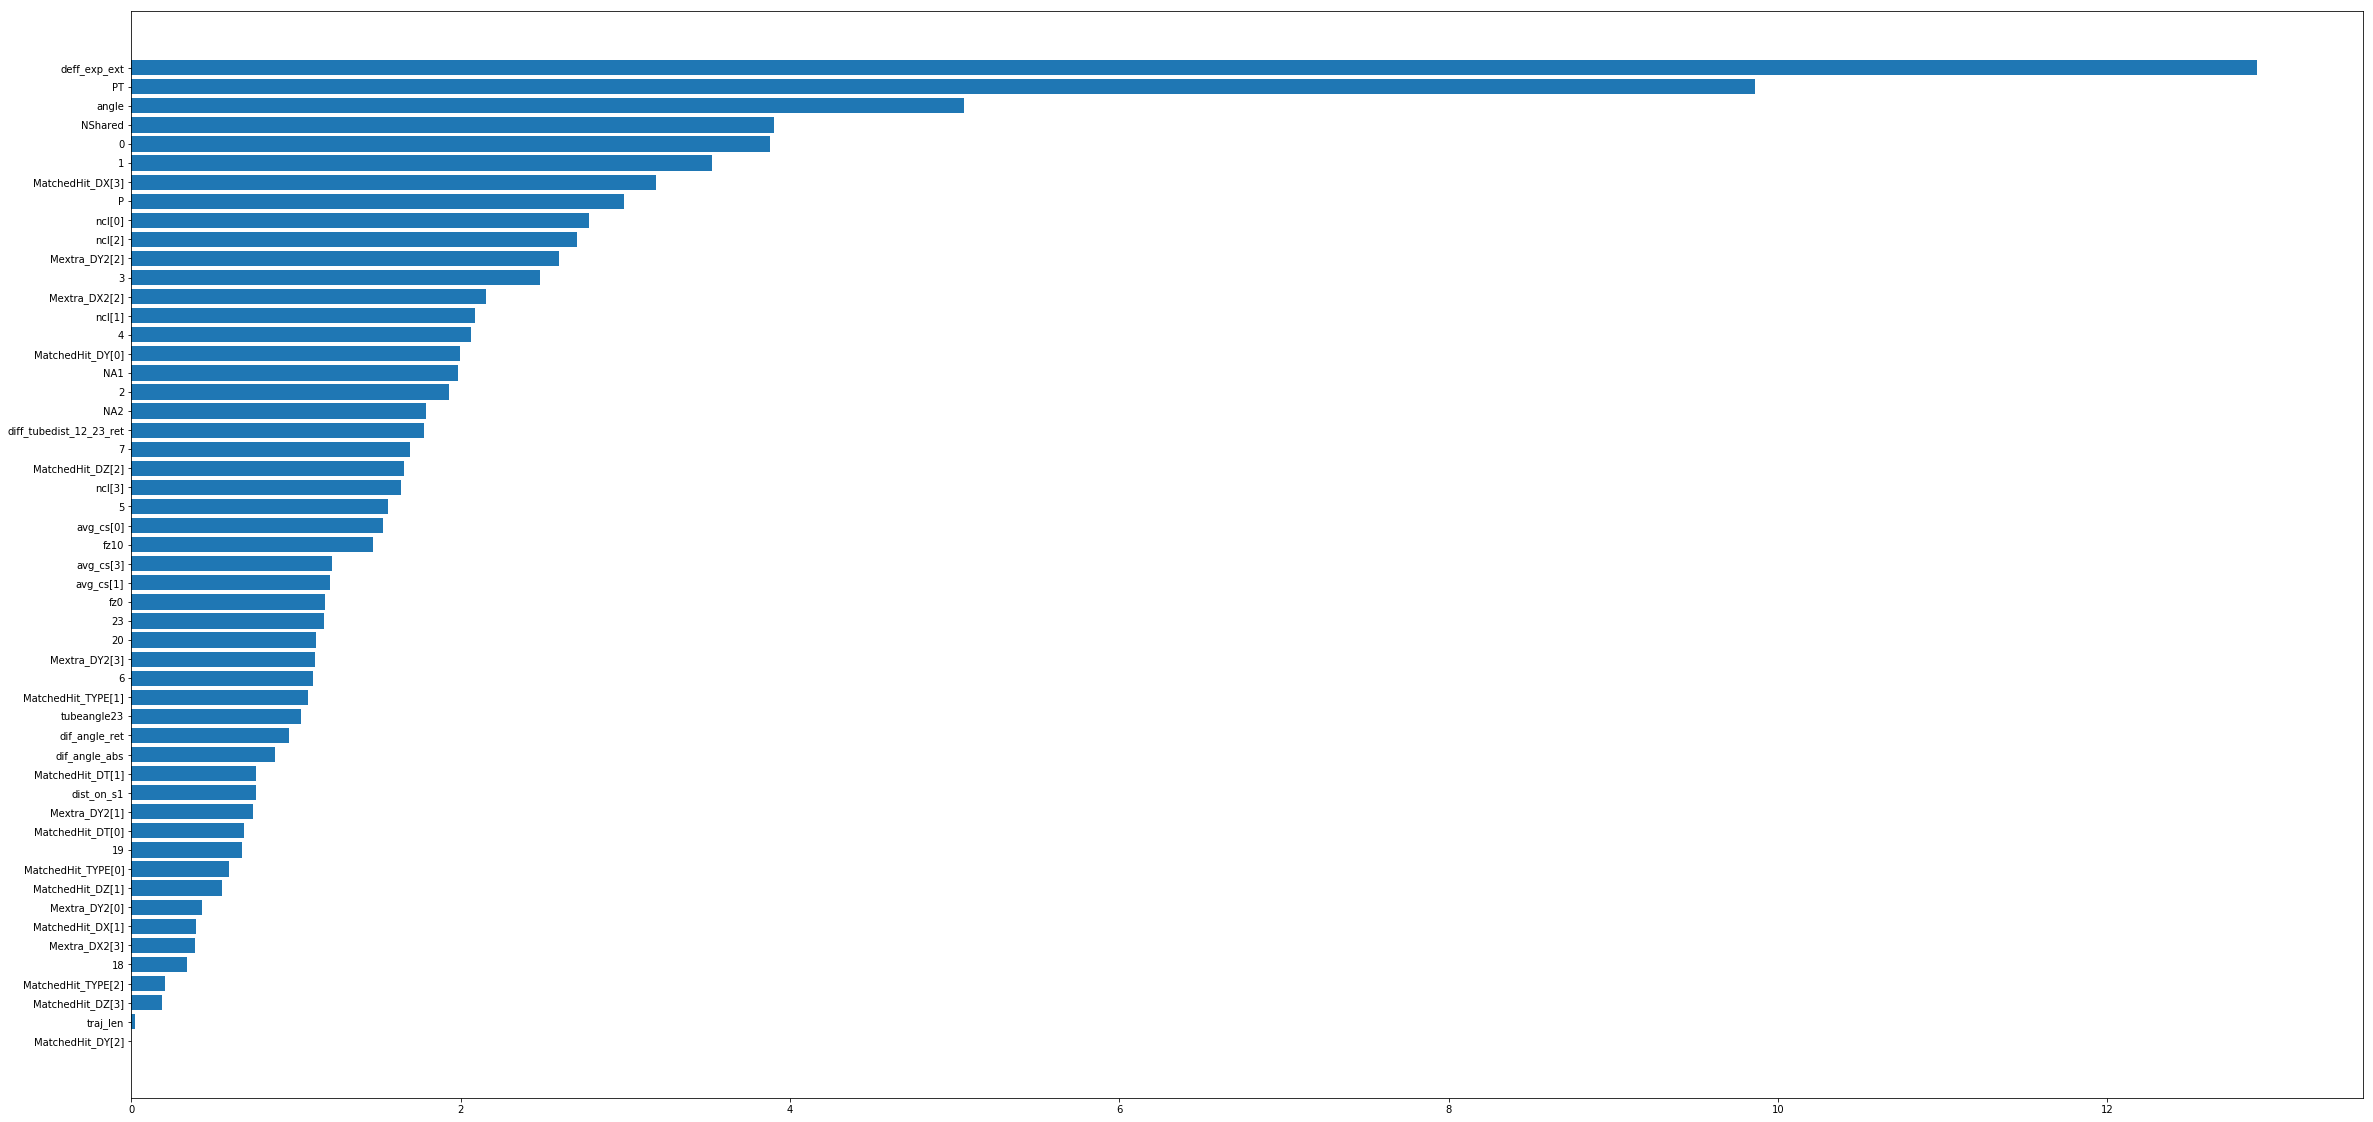

deff_exp_ext
PT
angle
NShared
0
1
MatchedHit_DX[3]
P
ncl[0]
ncl[2]


In [65]:
from collections import OrderedDict
from matplotlib import pyplot as plt
%matplotlib inline
feature_dict = {k:v for k,v in zip(m.feature_names_, 
                                   m.feature_importances_)}
feature_dict = OrderedDict(sorted(feature_dict.items(), key = lambda x:x[1]))

plt.figure(figsize = (40, 20))
plt.barh(list(range(len(feature_dict))), list(feature_dict.values()))
plt.yticks(range(len(feature_dict)), list(feature_dict.keys()))
plt.show()

print('\n'.join([i[0] for i in list(feature_dict.items())[-10:][::-1]]))

In [64]:
# feature_dict.items()

In [67]:
df_train['frac_P_PT'] = df_train['PT']/df_train['P']
df_train['dot_P_PT'] =  df_train['PT']*df_train['P']

df_train['frac_P_deff_exp_ext'] = df_train['deff_exp_ext'] / df_train['P']
df_train['dot_P_deff_exp_ext'] =  df_train['deff_exp_ext'] * df_train['P']

df_train['frac_P_NShared'] = df_train['NShared'] / df_train['P']
df_train['dot_P_NShared'] =  df_train['NShared'] * df_train['P']

df_train['frac_P_angle'] = df_train['angle'] / df_train['P']
df_train['dot_P_angle'] =  df_train['angle'] * df_train['P']

df_train['frac_P_0'] = df_train['0'] / df_train['P']
df_train['dot_P_0'] =  df_train['0'] * df_train['P']

df_train['frac_P_1'] = df_train['1'] / df_train['P']
df_train['dot_P_1'] =  df_train['1'] * df_train['P']

In [69]:
from tqdm import tqdm_notebook
df_train['MatchedHit_TYPE'] = df_train['MatchedHit_TYPE[0]'].astype(str)+\
                              df_train['MatchedHit_TYPE[1]'].astype(str)+\
                              df_train['MatchedHit_TYPE[2]'].astype(str)+\
                              df_train['MatchedHit_TYPE[3]'].astype(str)
            

            
df_train['HitFirstZero'] = [(i+'0').index('0') for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitHasTwoZero'] = ['00' in i for i in  tqdm_notebook(df_train['MatchedHit_TYPE'])]

def foo_speed(s):
    i1,i2,i3,i4 = [int(i) for i in s]
    return i4+i3*3+i2*3*2+i1**3*2*2

def foo_speed_revert(s):
    i1,i2,i3,i4 = [int(i) for i in s]
    return i4*3*3*2+i3*3*2+i2*2+i1

def foo_speed_xor1(s):
    i1,i2,i3,i4 = [((int(i)+1)%3) for i in s]
    return i4+i3*3+i2*3*2+i1**3*2*2

def foo_speed_xor2(s):
    i1,i2,i3,i4 = [((int(i)+2)%3) for i in s]
    return i4+i3*3+i2*3*2+i1**3*2*2

def foo_speed_xor1_revert(s):
    i1,i2,i3,i4 = [((int(i)+1)%3) for i in s]
    return i4*3*3*2+i3*3*2+i2*2+i1


def foo_speed_xor2_revert(s):
    i1,i2,i3,i4 = [((int(i)+2)%3) for i in s]
    return i4*3*3*2+i3*3*2+i2*2+i1

        
df_train['HitSpeed'] = [foo_speed(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitSpeedRev'] = [foo_speed_revert(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]

df_train['HitSpeedXor1'] = [foo_speed_xor1(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitSpeedRevXor1'] = [foo_speed_xor1_revert(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]


df_train['HitSpeedXor2'] = [foo_speed_xor2(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]
df_train['HitSpeedRevXor2'] = [foo_speed_xor2_revert(i) for i in tqdm_notebook(df_train['MatchedHit_TYPE'])]

del df_train['MatchedHit_TYPE']

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5445705), HTML(value='')))

    Автоматический отбор feature_importance
    Тренируем модель, выкидываем две худшие фичи

In [76]:
%%time
df_train_part, df_validation = train_test_split(df_train, test_size=0.25, shuffle=True, random_state = 42)

CPU times: user 10.8 s, sys: 4.95 s, total: 15.8 s
Wall time: 15.7 s


In [ ]:
features = list(df_train.keys())
for bad_feat in ['particle_type', 'label', 'sWeight', 'kinWeight', 'weight']:
    if bad_feat in features:
        features.remove(bad_feat)
    else:
        sys.stdout.write(bad_feat+', ')

target = ['label']

for n_iter in tqdm_notebook(range(160)):
    m = catboost.CatBoostClassifier(iterations=120, max_depth=8,
                                    learning_rate = 0.2,
                                    use_best_model = True,
                                    train_dir='feature_dropping1/feature_dropping_%d_new'%(n_iter),
                                    thread_count=24, verbose=True,
                                    custom_loss = ['Logloss', 'AUC','Precision','Recall','F1'],
                                    loss_function='CrossEntropy')

    eval_set = (df_validation[features], 
                df_validation[target])

    
    m.fit(df_train_part[features], 
          df_train_part[target], 
          eval_set = eval_set,
          sample_weight = np.abs(df_train_part['weight']),
          plot = False)
    
    feature_dict = {k:v for k,v in zip(m.feature_names_, 
                                   m.feature_importances_)}


    

    feature_dict = OrderedDict(sorted(feature_dict.items(), key = lambda x:x[1]))
    
    bad_features = list(feature_dict.keys())[:1]
    print(list(feature_dict.items())[:2])
    for bad_f in bad_features:
        features.remove(bad_f)
    
    print('n_iter:\t', str(score))
    try:
        score = scoring.rejection90(df_validation.label.get_values(), 
                                    m.predict_proba(df_validation[features])[:, 1], 
                                    sample_weight = df_validation['weight'].get_values())
        dirty_dump = {'score':score, 'model':m, 'feat_dict':feature_dict, 'feat':features}
        pickle.dump(dirty_dump, open('feature_dropping1/dirty%d.pickle'%(n_iter), 'wb'))
    except:
        try:
            print('!!!ERROR!!!')
            pickle.dump({'model':m, 'feat_dict':feature_dict, 'feat':features}, 
                        open('feature_dropping/dirty%d.pickle'%(n_iter), 'wb'))
        except:
            pass
        pass

HBox(children=(IntProgress(value=0, max=160), HTML(value='')))

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



0:	learn: 0.6237410	test: 0.6676301	best: 0.6676301 (0)	total: 1.1s	remaining: 2m 10s
1:	learn: 0.5795873	test: 0.6543572	best: 0.6543572 (1)	total: 2.16s	remaining: 2m 7s
2:	learn: 0.5536641	test: 0.6499371	best: 0.6499371 (2)	total: 3.17s	remaining: 2m 3s
3:	learn: 0.5329388	test: 0.6438386	best: 0.6438386 (3)	total: 4.26s	remaining: 2m 3s
4:	learn: 0.5195176	test: 0.6408079	best: 0.6408079 (4)	total: 5.35s	remaining: 2m 3s
5:	learn: 0.5110282	test: 0.6397888	best: 0.6397888 (5)	total: 6.45s	remaining: 2m 2s
6:	learn: 0.5065757	test: 0.6407898	best: 0.6397888 (5)	total: 7.63s	remaining: 2m 3s
7:	learn: 0.5005356	test: 0.6396092	best: 0.6396092 (7)	total: 8.77s	remaining: 2m 2s
8:	learn: 0.4963724	test: 0.6386081	best: 0.6386081 (8)	total: 9.9s	remaining: 2m 2s
9:	learn: 0.4922650	test: 0.6367645	best: 0.6367645 (9)	total: 11s	remaining: 2m 1s
10:	learn: 0.4886567	test: 0.6345440	best: 0.6345440 (10)	total: 12.2s	remaining: 2m
11:	learn: 0.4867880	test: 0.6333210	best: 0.6333210 (11)	

93:	learn: 0.4405815	test: 0.5801135	best: 0.5801135 (93)	total: 1m 47s	remaining: 29.7s
94:	learn: 0.4402119	test: 0.5796341	best: 0.5796341 (94)	total: 1m 48s	remaining: 28.5s
95:	learn: 0.4399121	test: 0.5793258	best: 0.5793258 (95)	total: 1m 49s	remaining: 27.4s
96:	learn: 0.4394910	test: 0.5787583	best: 0.5787583 (96)	total: 1m 50s	remaining: 26.3s
97:	learn: 0.4391314	test: 0.5782830	best: 0.5782830 (97)	total: 1m 51s	remaining: 25.1s
98:	learn: 0.4387930	test: 0.5778605	best: 0.5778605 (98)	total: 1m 52s	remaining: 24s
99:	learn: 0.4383602	test: 0.5773988	best: 0.5773988 (99)	total: 1m 54s	remaining: 22.8s
100:	learn: 0.4378899	test: 0.5768239	best: 0.5768239 (100)	total: 1m 55s	remaining: 21.7s
101:	learn: 0.4375508	test: 0.5764185	best: 0.5764185 (101)	total: 1m 56s	remaining: 20.6s
102:	learn: 0.4372908	test: 0.5760578	best: 0.5760578 (102)	total: 1m 57s	remaining: 19.4s
103:	learn: 0.4369736	test: 0.5757142	best: 0.5757142 (103)	total: 1m 58s	remaining: 18.3s
104:	learn: 0.4

15:	learn: 0.4815493	test: 0.6298031	best: 0.6298031 (15)	total: 17.9s	remaining: 1m 56s
16:	learn: 0.4803202	test: 0.6287307	best: 0.6287307 (16)	total: 19.1s	remaining: 1m 55s
17:	learn: 0.4792689	test: 0.6278608	best: 0.6278608 (17)	total: 20.3s	remaining: 1m 54s
18:	learn: 0.4782079	test: 0.6265376	best: 0.6265376 (18)	total: 21.4s	remaining: 1m 53s
19:	learn: 0.4770644	test: 0.6255321	best: 0.6255321 (19)	total: 22.4s	remaining: 1m 51s
20:	learn: 0.4759393	test: 0.6241133	best: 0.6241133 (20)	total: 23.5s	remaining: 1m 50s
21:	learn: 0.4751017	test: 0.6231421	best: 0.6231421 (21)	total: 24.6s	remaining: 1m 49s
22:	learn: 0.4744991	test: 0.6223936	best: 0.6223936 (22)	total: 25.7s	remaining: 1m 48s
23:	learn: 0.4736058	test: 0.6216123	best: 0.6216123 (23)	total: 26.8s	remaining: 1m 47s
24:	learn: 0.4726551	test: 0.6205508	best: 0.6205508 (24)	total: 28s	remaining: 1m 46s
25:	learn: 0.4716243	test: 0.6195491	best: 0.6195491 (25)	total: 29.1s	remaining: 1m 45s
26:	learn: 0.4709472	te

108:	learn: 0.4362463	test: 0.5757712	best: 0.5757712 (108)	total: 2m 3s	remaining: 12.5s
109:	learn: 0.4358834	test: 0.5753509	best: 0.5753509 (109)	total: 2m 4s	remaining: 11.3s
110:	learn: 0.4355664	test: 0.5749565	best: 0.5749565 (110)	total: 2m 5s	remaining: 10.2s
111:	learn: 0.4351075	test: 0.5743823	best: 0.5743823 (111)	total: 2m 7s	remaining: 9.07s
112:	learn: 0.4347416	test: 0.5739080	best: 0.5739080 (112)	total: 2m 8s	remaining: 7.94s
113:	learn: 0.4342290	test: 0.5733161	best: 0.5733161 (113)	total: 2m 9s	remaining: 6.8s
114:	learn: 0.4339021	test: 0.5729082	best: 0.5729082 (114)	total: 2m 10s	remaining: 5.67s
115:	learn: 0.4335204	test: 0.5724649	best: 0.5724649 (115)	total: 2m 11s	remaining: 4.54s
116:	learn: 0.4331135	test: 0.5719668	best: 0.5719668 (116)	total: 2m 12s	remaining: 3.4s
117:	learn: 0.4327522	test: 0.5713546	best: 0.5713546 (117)	total: 2m 13s	remaining: 2.27s
118:	learn: 0.4323788	test: 0.5708500	best: 0.5708500 (118)	total: 2m 15s	remaining: 1.13s
119:	le

80:	learn: 0.4475945	test: 0.5892179	best: 0.5892179 (80)	total: 1m 31s	remaining: 44.1s
81:	learn: 0.4470754	test: 0.5886711	best: 0.5886711 (81)	total: 1m 32s	remaining: 43s
82:	learn: 0.4468279	test: 0.5883422	best: 0.5883422 (82)	total: 1m 33s	remaining: 41.8s
83:	learn: 0.4463243	test: 0.5877361	best: 0.5877361 (83)	total: 1m 35s	remaining: 40.7s
84:	learn: 0.4457622	test: 0.5871767	best: 0.5871767 (84)	total: 1m 36s	remaining: 39.6s
85:	learn: 0.4454066	test: 0.5866362	best: 0.5866362 (85)	total: 1m 37s	remaining: 38.5s
86:	learn: 0.4444311	test: 0.5856261	best: 0.5856261 (86)	total: 1m 38s	remaining: 37.3s
87:	learn: 0.4439160	test: 0.5849383	best: 0.5849383 (87)	total: 1m 39s	remaining: 36.2s
88:	learn: 0.4435839	test: 0.5844278	best: 0.5844278 (88)	total: 1m 40s	remaining: 35.1s
89:	learn: 0.4432697	test: 0.5839551	best: 0.5839551 (89)	total: 1m 41s	remaining: 33.9s
90:	learn: 0.4429268	test: 0.5835300	best: 0.5835300 (90)	total: 1m 42s	remaining: 32.8s
91:	learn: 0.4424837	te

51:	learn: 0.4588318	test: 0.6031880	best: 0.6031880 (51)	total: 58.5s	remaining: 1m 16s
52:	learn: 0.4585718	test: 0.6028643	best: 0.6028643 (52)	total: 59.5s	remaining: 1m 15s
53:	learn: 0.4580890	test: 0.6021964	best: 0.6021964 (53)	total: 1m	remaining: 1m 14s
54:	learn: 0.4575389	test: 0.6014943	best: 0.6014943 (54)	total: 1m 1s	remaining: 1m 13s
55:	learn: 0.4572721	test: 0.6011223	best: 0.6011223 (55)	total: 1m 3s	remaining: 1m 12s
56:	learn: 0.4567418	test: 0.6005901	best: 0.6005901 (56)	total: 1m 4s	remaining: 1m 11s
57:	learn: 0.4563259	test: 0.6000539	best: 0.6000539 (57)	total: 1m 5s	remaining: 1m 9s
58:	learn: 0.4557756	test: 0.5994195	best: 0.5994195 (58)	total: 1m 6s	remaining: 1m 8s
59:	learn: 0.4553583	test: 0.5988451	best: 0.5988451 (59)	total: 1m 7s	remaining: 1m 7s
60:	learn: 0.4550290	test: 0.5983957	best: 0.5983957 (60)	total: 1m 8s	remaining: 1m 6s
61:	learn: 0.4546774	test: 0.5978809	best: 0.5978809 (61)	total: 1m 9s	remaining: 1m 5s
62:	learn: 0.4539856	test: 0.

22:	learn: 0.4744594	test: 0.6235053	best: 0.6235053 (22)	total: 25.6s	remaining: 1m 47s
23:	learn: 0.4737784	test: 0.6224702	best: 0.6224702 (23)	total: 26.7s	remaining: 1m 46s
24:	learn: 0.4732921	test: 0.6219266	best: 0.6219266 (24)	total: 27.7s	remaining: 1m 45s
25:	learn: 0.4725348	test: 0.6211099	best: 0.6211099 (25)	total: 28.9s	remaining: 1m 44s
26:	learn: 0.4718197	test: 0.6199827	best: 0.6199827 (26)	total: 30.2s	remaining: 1m 43s
27:	learn: 0.4711315	test: 0.6191822	best: 0.6191822 (27)	total: 31.4s	remaining: 1m 43s
28:	learn: 0.4704896	test: 0.6184022	best: 0.6184022 (28)	total: 32.5s	remaining: 1m 41s
29:	learn: 0.4698499	test: 0.6177725	best: 0.6177725 (29)	total: 33.5s	remaining: 1m 40s
30:	learn: 0.4692770	test: 0.6172881	best: 0.6172881 (30)	total: 34.7s	remaining: 1m 39s
31:	learn: 0.4689474	test: 0.6167815	best: 0.6167815 (31)	total: 35.7s	remaining: 1m 38s
32:	learn: 0.4683698	test: 0.6160719	best: 0.6160719 (32)	total: 36.8s	remaining: 1m 36s
33:	learn: 0.4674416	

115:	learn: 0.4336474	test: 0.5727426	best: 0.5727426 (115)	total: 2m 10s	remaining: 4.5s
116:	learn: 0.4332031	test: 0.5722013	best: 0.5722013 (116)	total: 2m 11s	remaining: 3.37s
117:	learn: 0.4329396	test: 0.5718942	best: 0.5718942 (117)	total: 2m 12s	remaining: 2.25s
118:	learn: 0.4325249	test: 0.5714449	best: 0.5714449 (118)	total: 2m 13s	remaining: 1.12s
119:	learn: 0.4323109	test: 0.5712007	best: 0.5712007 (119)	total: 2m 14s	remaining: 0us

bestTest = 0.5712006991
bestIteration = 119

[('MatchedHit_DZ[1]', 0.0), ('15', 0.0)]
n_iter:	 0.7553911567282433
0:	learn: 0.6245437	test: 0.6666976	best: 0.6666976 (0)	total: 1.13s	remaining: 2m 14s
1:	learn: 0.5777918	test: 0.6542103	best: 0.6542103 (1)	total: 2.28s	remaining: 2m 14s
2:	learn: 0.5514327	test: 0.6479914	best: 0.6479914 (2)	total: 3.36s	remaining: 2m 11s
3:	learn: 0.5337574	test: 0.6455810	best: 0.6455810 (3)	total: 4.42s	remaining: 2m 8s
4:	learn: 0.5188829	test: 0.6411836	best: 0.6411836 (4)	total: 5.56s	remaining: 2m 7s


87:	learn: 0.4461497	test: 0.5872851	best: 0.5872851 (87)	total: 1m 39s	remaining: 36.1s
88:	learn: 0.4458430	test: 0.5869418	best: 0.5869418 (88)	total: 1m 40s	remaining: 35s
89:	learn: 0.4452392	test: 0.5861765	best: 0.5861765 (89)	total: 1m 41s	remaining: 33.8s
90:	learn: 0.4448173	test: 0.5856481	best: 0.5856481 (90)	total: 1m 42s	remaining: 32.7s
91:	learn: 0.4443582	test: 0.5850911	best: 0.5850911 (91)	total: 1m 43s	remaining: 31.6s
92:	learn: 0.4439946	test: 0.5846842	best: 0.5846842 (92)	total: 1m 44s	remaining: 30.4s
93:	learn: 0.4431378	test: 0.5838422	best: 0.5838422 (93)	total: 1m 46s	remaining: 29.4s
94:	learn: 0.4425796	test: 0.5831190	best: 0.5831190 (94)	total: 1m 47s	remaining: 28.3s
95:	learn: 0.4422159	test: 0.5825746	best: 0.5825746 (95)	total: 1m 48s	remaining: 27.1s
96:	learn: 0.4417062	test: 0.5818857	best: 0.5818857 (96)	total: 1m 49s	remaining: 26s
97:	learn: 0.4413706	test: 0.5814467	best: 0.5814467 (97)	total: 1m 50s	remaining: 24.9s
98:	learn: 0.4410986	test

58:	learn: 0.4549871	test: 0.5992641	best: 0.5992641 (58)	total: 1m 7s	remaining: 1m 9s
59:	learn: 0.4545623	test: 0.5987619	best: 0.5987619 (59)	total: 1m 8s	remaining: 1m 8s
60:	learn: 0.4541028	test: 0.5981426	best: 0.5981426 (60)	total: 1m 9s	remaining: 1m 7s
61:	learn: 0.4537571	test: 0.5976252	best: 0.5976252 (61)	total: 1m 10s	remaining: 1m 6s
62:	learn: 0.4532725	test: 0.5969676	best: 0.5969676 (62)	total: 1m 11s	remaining: 1m 5s
63:	learn: 0.4528768	test: 0.5964599	best: 0.5964599 (63)	total: 1m 13s	remaining: 1m 3s
64:	learn: 0.4524256	test: 0.5959527	best: 0.5959527 (64)	total: 1m 14s	remaining: 1m 2s
65:	learn: 0.4521712	test: 0.5956567	best: 0.5956567 (65)	total: 1m 15s	remaining: 1m 1s
66:	learn: 0.4516921	test: 0.5950541	best: 0.5950541 (66)	total: 1m 16s	remaining: 1m
67:	learn: 0.4513183	test: 0.5945282	best: 0.5945282 (67)	total: 1m 18s	remaining: 59.7s
68:	learn: 0.4509349	test: 0.5940706	best: 0.5940706 (68)	total: 1m 19s	remaining: 58.5s
69:	learn: 0.4504725	test: 

29:	learn: 0.4693594	test: 0.6164719	best: 0.6164719 (29)	total: 33.9s	remaining: 1m 41s
30:	learn: 0.4690544	test: 0.6159463	best: 0.6159463 (30)	total: 35s	remaining: 1m 40s
31:	learn: 0.4683935	test: 0.6152097	best: 0.6152097 (31)	total: 36s	remaining: 1m 39s
32:	learn: 0.4679963	test: 0.6147010	best: 0.6147010 (32)	total: 37.2s	remaining: 1m 38s
33:	learn: 0.4671056	test: 0.6136617	best: 0.6136617 (33)	total: 38.2s	remaining: 1m 36s
34:	learn: 0.4664888	test: 0.6126809	best: 0.6126809 (34)	total: 39.3s	remaining: 1m 35s
35:	learn: 0.4659584	test: 0.6120859	best: 0.6120859 (35)	total: 40.5s	remaining: 1m 34s
36:	learn: 0.4652485	test: 0.6113334	best: 0.6113334 (36)	total: 41.6s	remaining: 1m 33s
37:	learn: 0.4648328	test: 0.6110567	best: 0.6110567 (37)	total: 42.7s	remaining: 1m 32s
38:	learn: 0.4643766	test: 0.6104752	best: 0.6104752 (38)	total: 44s	remaining: 1m 31s
39:	learn: 0.4640601	test: 0.6100872	best: 0.6100872 (39)	total: 45.3s	remaining: 1m 30s
40:	learn: 0.4636465	test: 

0:	learn: 0.6213612	test: 0.6653091	best: 0.6653091 (0)	total: 1.09s	remaining: 2m 9s
1:	learn: 0.5783262	test: 0.6517476	best: 0.6517476 (1)	total: 2.18s	remaining: 2m 8s
2:	learn: 0.5501983	test: 0.6457151	best: 0.6457151 (2)	total: 3.31s	remaining: 2m 9s
3:	learn: 0.5327339	test: 0.6429410	best: 0.6429410 (3)	total: 4.4s	remaining: 2m 7s
4:	learn: 0.5194673	test: 0.6399164	best: 0.6399164 (4)	total: 5.43s	remaining: 2m 4s
5:	learn: 0.5087775	test: 0.6378883	best: 0.6378883 (5)	total: 6.53s	remaining: 2m 4s
6:	learn: 0.5028460	test: 0.6362149	best: 0.6362149 (6)	total: 7.66s	remaining: 2m 3s
7:	learn: 0.4986648	test: 0.6361092	best: 0.6361092 (7)	total: 8.65s	remaining: 2m 1s
8:	learn: 0.4952782	test: 0.6361980	best: 0.6361092 (7)	total: 9.81s	remaining: 2m
9:	learn: 0.4919630	test: 0.6353105	best: 0.6353105 (9)	total: 10.9s	remaining: 2m
10:	learn: 0.4882596	test: 0.6335028	best: 0.6335028 (10)	total: 12.1s	remaining: 1m 59s
11:	learn: 0.4852447	test: 0.6318133	best: 0.6318133 (11)	

93:	learn: 0.4420237	test: 0.5828558	best: 0.5828558 (93)	total: 1m 45s	remaining: 29.3s
94:	learn: 0.4415061	test: 0.5821936	best: 0.5821936 (94)	total: 1m 47s	remaining: 28.2s
95:	learn: 0.4411996	test: 0.5818502	best: 0.5818502 (95)	total: 1m 48s	remaining: 27s
96:	learn: 0.4406953	test: 0.5811554	best: 0.5811554 (96)	total: 1m 49s	remaining: 25.9s
97:	learn: 0.4403394	test: 0.5807407	best: 0.5807407 (97)	total: 1m 50s	remaining: 24.8s
98:	learn: 0.4400132	test: 0.5803558	best: 0.5803558 (98)	total: 1m 51s	remaining: 23.7s
99:	learn: 0.4396142	test: 0.5798636	best: 0.5798636 (99)	total: 1m 52s	remaining: 22.6s
100:	learn: 0.4393178	test: 0.5795004	best: 0.5795004 (100)	total: 1m 53s	remaining: 21.4s
101:	learn: 0.4390069	test: 0.5791398	best: 0.5791398 (101)	total: 1m 55s	remaining: 20.3s
102:	learn: 0.4385525	test: 0.5786423	best: 0.5786423 (102)	total: 1m 56s	remaining: 19.2s
103:	learn: 0.4381181	test: 0.5782082	best: 0.5782082 (103)	total: 1m 57s	remaining: 18s
104:	learn: 0.437

64:	learn: 0.4534623	test: 0.5967277	best: 0.5967277 (64)	total: 1m 12s	remaining: 1m 1s
65:	learn: 0.4529175	test: 0.5960340	best: 0.5960340 (65)	total: 1m 14s	remaining: 1m
66:	learn: 0.4525773	test: 0.5954998	best: 0.5954998 (66)	total: 1m 15s	remaining: 59.6s
67:	learn: 0.4523035	test: 0.5951738	best: 0.5951738 (67)	total: 1m 16s	remaining: 58.4s
68:	learn: 0.4520650	test: 0.5948628	best: 0.5948628 (68)	total: 1m 17s	remaining: 57.4s
69:	learn: 0.4517771	test: 0.5943974	best: 0.5943974 (69)	total: 1m 18s	remaining: 56.2s
70:	learn: 0.4515202	test: 0.5940428	best: 0.5940428 (70)	total: 1m 19s	remaining: 55.1s
71:	learn: 0.4508366	test: 0.5932435	best: 0.5932435 (71)	total: 1m 20s	remaining: 53.9s
72:	learn: 0.4504557	test: 0.5927763	best: 0.5927763 (72)	total: 1m 22s	remaining: 52.8s
73:	learn: 0.4500289	test: 0.5922289	best: 0.5922289 (73)	total: 1m 23s	remaining: 51.7s
74:	learn: 0.4497890	test: 0.5918929	best: 0.5918929 (74)	total: 1m 24s	remaining: 50.6s
75:	learn: 0.4495812	tes

35:	learn: 0.4656257	test: 0.6124231	best: 0.6124231 (35)	total: 40.2s	remaining: 1m 33s
36:	learn: 0.4651519	test: 0.6118886	best: 0.6118886 (36)	total: 41.3s	remaining: 1m 32s
37:	learn: 0.4645565	test: 0.6111951	best: 0.6111951 (37)	total: 42.4s	remaining: 1m 31s
38:	learn: 0.4640810	test: 0.6105640	best: 0.6105640 (38)	total: 43.8s	remaining: 1m 31s
39:	learn: 0.4636548	test: 0.6099914	best: 0.6099914 (39)	total: 44.9s	remaining: 1m 29s
40:	learn: 0.4630889	test: 0.6093792	best: 0.6093792 (40)	total: 45.9s	remaining: 1m 28s
41:	learn: 0.4628111	test: 0.6089561	best: 0.6089561 (41)	total: 47s	remaining: 1m 27s
42:	learn: 0.4624290	test: 0.6084604	best: 0.6084604 (42)	total: 48.1s	remaining: 1m 26s
43:	learn: 0.4618842	test: 0.6079388	best: 0.6079388 (43)	total: 49.3s	remaining: 1m 25s
44:	learn: 0.4615692	test: 0.6076041	best: 0.6076041 (44)	total: 50.4s	remaining: 1m 24s
45:	learn: 0.4605046	test: 0.6065269	best: 0.6065269 (45)	total: 51.6s	remaining: 1m 23s
46:	learn: 0.4602415	te

7:	learn: 0.4997418	test: 0.6376341	best: 0.6376341 (7)	total: 8.9s	remaining: 2m 4s
8:	learn: 0.4962857	test: 0.6368894	best: 0.6368894 (8)	total: 10s	remaining: 2m 3s
9:	learn: 0.4932893	test: 0.6363250	best: 0.6363250 (9)	total: 11.1s	remaining: 2m 2s
10:	learn: 0.4893557	test: 0.6341840	best: 0.6341840 (10)	total: 12.2s	remaining: 2m
11:	learn: 0.4870419	test: 0.6328541	best: 0.6328541 (11)	total: 13.5s	remaining: 2m 1s
12:	learn: 0.4852719	test: 0.6318095	best: 0.6318095 (12)	total: 14.6s	remaining: 2m
13:	learn: 0.4836681	test: 0.6308661	best: 0.6308661 (13)	total: 15.7s	remaining: 1m 58s
14:	learn: 0.4820863	test: 0.6296735	best: 0.6296735 (14)	total: 16.8s	remaining: 1m 57s
15:	learn: 0.4808957	test: 0.6285813	best: 0.6285813 (15)	total: 18s	remaining: 1m 56s
16:	learn: 0.4796931	test: 0.6273748	best: 0.6273748 (16)	total: 19.1s	remaining: 1m 55s
17:	learn: 0.4786917	test: 0.6267039	best: 0.6267039 (17)	total: 20.1s	remaining: 1m 54s
18:	learn: 0.4775520	test: 0.6255970	best: 0

100:	learn: 0.4393690	test: 0.5800623	best: 0.5800623 (100)	total: 1m 53s	remaining: 21.3s
101:	learn: 0.4389264	test: 0.5794985	best: 0.5794985 (101)	total: 1m 54s	remaining: 20.2s
102:	learn: 0.4379638	test: 0.5783673	best: 0.5783673 (102)	total: 1m 55s	remaining: 19.1s
103:	learn: 0.4375394	test: 0.5777915	best: 0.5777915 (103)	total: 1m 56s	remaining: 18s
104:	learn: 0.4371323	test: 0.5772158	best: 0.5772158 (104)	total: 1m 57s	remaining: 16.8s
105:	learn: 0.4368738	test: 0.5768658	best: 0.5768658 (105)	total: 1m 58s	remaining: 15.7s
106:	learn: 0.4364454	test: 0.5763091	best: 0.5763091 (106)	total: 2m	remaining: 14.6s
107:	learn: 0.4361354	test: 0.5759265	best: 0.5759265 (107)	total: 2m 1s	remaining: 13.5s
108:	learn: 0.4359295	test: 0.5756330	best: 0.5756330 (108)	total: 2m 2s	remaining: 12.3s
109:	learn: 0.4354689	test: 0.5750561	best: 0.5750561 (109)	total: 2m 3s	remaining: 11.2s
110:	learn: 0.4352002	test: 0.5747271	best: 0.5747271 (110)	total: 2m 4s	remaining: 10.1s
111:	lear

72:	learn: 0.4516825	test: 0.5948762	best: 0.5948762 (72)	total: 1m 21s	remaining: 52.4s
73:	learn: 0.4511268	test: 0.5941202	best: 0.5941202 (73)	total: 1m 22s	remaining: 51.3s
74:	learn: 0.4509248	test: 0.5937791	best: 0.5937791 (74)	total: 1m 23s	remaining: 50.1s
75:	learn: 0.4504173	test: 0.5931500	best: 0.5931500 (75)	total: 1m 24s	remaining: 49s
76:	learn: 0.4499329	test: 0.5925758	best: 0.5925758 (76)	total: 1m 25s	remaining: 47.8s
77:	learn: 0.4496006	test: 0.5921122	best: 0.5921122 (77)	total: 1m 26s	remaining: 46.7s
78:	learn: 0.4493083	test: 0.5916717	best: 0.5916717 (78)	total: 1m 27s	remaining: 45.6s
79:	learn: 0.4489133	test: 0.5911440	best: 0.5911440 (79)	total: 1m 29s	remaining: 44.5s
80:	learn: 0.4486067	test: 0.5906967	best: 0.5906967 (80)	total: 1m 30s	remaining: 43.4s
81:	learn: 0.4480704	test: 0.5901337	best: 0.5901337 (81)	total: 1m 31s	remaining: 42.3s
82:	learn: 0.4475635	test: 0.5894255	best: 0.5894255 (82)	total: 1m 32s	remaining: 41.1s
83:	learn: 0.4472337	te

43:	learn: 0.4626321	test: 0.6078429	best: 0.6078429 (43)	total: 48.9s	remaining: 1m 24s
44:	learn: 0.4623190	test: 0.6074279	best: 0.6074279 (44)	total: 50s	remaining: 1m 23s
45:	learn: 0.4619823	test: 0.6070461	best: 0.6070461 (45)	total: 51s	remaining: 1m 22s
46:	learn: 0.4615487	test: 0.6065931	best: 0.6065931 (46)	total: 52.1s	remaining: 1m 20s
47:	learn: 0.4611972	test: 0.6060511	best: 0.6060511 (47)	total: 53.3s	remaining: 1m 19s
48:	learn: 0.4604225	test: 0.6050599	best: 0.6050599 (48)	total: 54.5s	remaining: 1m 18s
49:	learn: 0.4601030	test: 0.6044944	best: 0.6044944 (49)	total: 55.5s	remaining: 1m 17s
50:	learn: 0.4593039	test: 0.6035490	best: 0.6035490 (50)	total: 56.5s	remaining: 1m 16s
51:	learn: 0.4588955	test: 0.6030470	best: 0.6030470 (51)	total: 57.7s	remaining: 1m 15s
52:	learn: 0.4586904	test: 0.6026091	best: 0.6026091 (52)	total: 58.8s	remaining: 1m 14s
53:	learn: 0.4582550	test: 0.6019962	best: 0.6019962 (53)	total: 59.9s	remaining: 1m 13s
54:	learn: 0.4578616	test

15:	learn: 0.4834709	test: 0.6330900	best: 0.6330900 (15)	total: 17.7s	remaining: 1m 55s
16:	learn: 0.4823930	test: 0.6321505	best: 0.6321505 (16)	total: 18.9s	remaining: 1m 54s
17:	learn: 0.4814838	test: 0.6312238	best: 0.6312238 (17)	total: 19.9s	remaining: 1m 53s
18:	learn: 0.4801203	test: 0.6297099	best: 0.6297099 (18)	total: 21.1s	remaining: 1m 51s
19:	learn: 0.4789171	test: 0.6282107	best: 0.6282107 (19)	total: 22.1s	remaining: 1m 50s
20:	learn: 0.4779388	test: 0.6273939	best: 0.6273939 (20)	total: 23.1s	remaining: 1m 48s
21:	learn: 0.4761116	test: 0.6256457	best: 0.6256457 (21)	total: 24.2s	remaining: 1m 47s
22:	learn: 0.4750457	test: 0.6243000	best: 0.6243000 (22)	total: 25.3s	remaining: 1m 46s
23:	learn: 0.4740047	test: 0.6232324	best: 0.6232324 (23)	total: 26.3s	remaining: 1m 45s
24:	learn: 0.4731210	test: 0.6222117	best: 0.6222117 (24)	total: 27.5s	remaining: 1m 44s
25:	learn: 0.4724629	test: 0.6214438	best: 0.6214438 (25)	total: 28.5s	remaining: 1m 43s
26:	learn: 0.4718430	

108:	learn: 0.4363641	test: 0.5758745	best: 0.5758745 (108)	total: 2m 1s	remaining: 12.2s
109:	learn: 0.4359187	test: 0.5753172	best: 0.5753172 (109)	total: 2m 2s	remaining: 11.1s
110:	learn: 0.4354076	test: 0.5746520	best: 0.5746520 (110)	total: 2m 3s	remaining: 10s
111:	learn: 0.4349232	test: 0.5740184	best: 0.5740184 (111)	total: 2m 4s	remaining: 8.92s
112:	learn: 0.4345586	test: 0.5735191	best: 0.5735191 (112)	total: 2m 5s	remaining: 7.8s
113:	learn: 0.4342310	test: 0.5730960	best: 0.5730960 (113)	total: 2m 7s	remaining: 6.69s
114:	learn: 0.4338997	test: 0.5726499	best: 0.5726499 (114)	total: 2m 8s	remaining: 5.57s
115:	learn: 0.4335419	test: 0.5722537	best: 0.5722537 (115)	total: 2m 9s	remaining: 4.46s
116:	learn: 0.4330949	test: 0.5718020	best: 0.5718020 (116)	total: 2m 10s	remaining: 3.35s
117:	learn: 0.4327156	test: 0.5713690	best: 0.5713690 (117)	total: 2m 11s	remaining: 2.23s
118:	learn: 0.4323897	test: 0.5709814	best: 0.5709814 (118)	total: 2m 12s	remaining: 1.12s
119:	learn

80:	learn: 0.4475830	test: 0.5904632	best: 0.5904632 (80)	total: 1m 30s	remaining: 43.6s
81:	learn: 0.4471980	test: 0.5900090	best: 0.5900090 (81)	total: 1m 31s	remaining: 42.5s
82:	learn: 0.4467256	test: 0.5895213	best: 0.5895213 (82)	total: 1m 32s	remaining: 41.4s
83:	learn: 0.4462046	test: 0.5888287	best: 0.5888287 (83)	total: 1m 33s	remaining: 40.3s
84:	learn: 0.4458601	test: 0.5884343	best: 0.5884343 (84)	total: 1m 35s	remaining: 39.1s
85:	learn: 0.4455604	test: 0.5879900	best: 0.5879900 (85)	total: 1m 36s	remaining: 38s
86:	learn: 0.4447255	test: 0.5869620	best: 0.5869620 (86)	total: 1m 37s	remaining: 37s
87:	learn: 0.4443175	test: 0.5863699	best: 0.5863699 (87)	total: 1m 38s	remaining: 35.9s
88:	learn: 0.4436757	test: 0.5854659	best: 0.5854659 (88)	total: 1m 39s	remaining: 34.8s
89:	learn: 0.4432471	test: 0.5848738	best: 0.5848738 (89)	total: 1m 40s	remaining: 33.7s
90:	learn: 0.4428052	test: 0.5842856	best: 0.5842856 (90)	total: 1m 42s	remaining: 32.5s
91:	learn: 0.4423931	test

52:	learn: 0.4580053	test: 0.6026108	best: 0.6026108 (52)	total: 58.7s	remaining: 1m 14s
53:	learn: 0.4575129	test: 0.6020867	best: 0.6020867 (53)	total: 1m	remaining: 1m 13s
54:	learn: 0.4572116	test: 0.6017063	best: 0.6017063 (54)	total: 1m 1s	remaining: 1m 12s
55:	learn: 0.4568947	test: 0.6012817	best: 0.6012817 (55)	total: 1m 2s	remaining: 1m 11s
56:	learn: 0.4564693	test: 0.6007667	best: 0.6007667 (56)	total: 1m 3s	remaining: 1m 10s
57:	learn: 0.4559548	test: 0.6001582	best: 0.6001582 (57)	total: 1m 5s	remaining: 1m 9s
58:	learn: 0.4554420	test: 0.5995125	best: 0.5995125 (58)	total: 1m 6s	remaining: 1m 8s
59:	learn: 0.4551372	test: 0.5990929	best: 0.5990929 (59)	total: 1m 7s	remaining: 1m 7s
60:	learn: 0.4548306	test: 0.5987326	best: 0.5987326 (60)	total: 1m 8s	remaining: 1m 5s
61:	learn: 0.4544402	test: 0.5982786	best: 0.5982786 (61)	total: 1m 9s	remaining: 1m 4s
62:	learn: 0.4539042	test: 0.5976470	best: 0.5976470 (62)	total: 1m 10s	remaining: 1m 3s
63:	learn: 0.4537600	test: 0.

23:	learn: 0.4731999	test: 0.6208972	best: 0.6208972 (23)	total: 26.4s	remaining: 1m 45s
24:	learn: 0.4725254	test: 0.6199160	best: 0.6199160 (24)	total: 27.5s	remaining: 1m 44s
25:	learn: 0.4719194	test: 0.6190950	best: 0.6190950 (25)	total: 28.5s	remaining: 1m 43s
26:	learn: 0.4711549	test: 0.6184146	best: 0.6184146 (26)	total: 29.7s	remaining: 1m 42s
27:	learn: 0.4705584	test: 0.6176872	best: 0.6176872 (27)	total: 30.8s	remaining: 1m 41s
28:	learn: 0.4701269	test: 0.6170202	best: 0.6170202 (28)	total: 31.9s	remaining: 1m 40s
29:	learn: 0.4689422	test: 0.6155552	best: 0.6155552 (29)	total: 33.3s	remaining: 1m 39s
30:	learn: 0.4682496	test: 0.6147474	best: 0.6147474 (30)	total: 34.4s	remaining: 1m 38s
31:	learn: 0.4675631	test: 0.6138116	best: 0.6138116 (31)	total: 35.5s	remaining: 1m 37s
32:	learn: 0.4669796	test: 0.6131474	best: 0.6131474 (32)	total: 36.6s	remaining: 1m 36s
33:	learn: 0.4665470	test: 0.6123344	best: 0.6123344 (33)	total: 37.6s	remaining: 1m 35s
34:	learn: 0.4654597	

116:	learn: 0.4320605	test: 0.5698322	best: 0.5698322 (116)	total: 2m 11s	remaining: 3.37s
117:	learn: 0.4317342	test: 0.5693877	best: 0.5693877 (117)	total: 2m 12s	remaining: 2.25s
118:	learn: 0.4313864	test: 0.5690178	best: 0.5690178 (118)	total: 2m 13s	remaining: 1.12s
119:	learn: 0.4310276	test: 0.5685232	best: 0.5685232 (119)	total: 2m 14s	remaining: 0us

bestTest = 0.5685232422
bestIteration = 119

[('MatchedHit_X[1]', 0.0), ('MatchedHit_Z[2]', 0.0)]
n_iter:	 0.744194981750712
0:	learn: 0.6223588	test: 0.6669920	best: 0.6669920 (0)	total: 1.08s	remaining: 2m 9s
1:	learn: 0.5799759	test: 0.6533672	best: 0.6533672 (1)	total: 2.19s	remaining: 2m 9s
2:	learn: 0.5523763	test: 0.6489039	best: 0.6489039 (2)	total: 3.25s	remaining: 2m 6s
3:	learn: 0.5309809	test: 0.6424735	best: 0.6424735 (3)	total: 4.31s	remaining: 2m 5s
4:	learn: 0.5198341	test: 0.6417519	best: 0.6417519 (4)	total: 5.43s	remaining: 2m 4s
5:	learn: 0.5110417	test: 0.6398543	best: 0.6398543 (5)	total: 6.7s	remaining: 2m 

88:	learn: 0.4435806	test: 0.5847855	best: 0.5847855 (88)	total: 1m 40s	remaining: 34.8s
89:	learn: 0.4432011	test: 0.5842606	best: 0.5842606 (89)	total: 1m 41s	remaining: 33.7s
90:	learn: 0.4428547	test: 0.5838315	best: 0.5838315 (90)	total: 1m 42s	remaining: 32.6s
91:	learn: 0.4424650	test: 0.5833303	best: 0.5833303 (91)	total: 1m 43s	remaining: 31.5s
92:	learn: 0.4419061	test: 0.5826566	best: 0.5826566 (92)	total: 1m 44s	remaining: 30.4s
93:	learn: 0.4415169	test: 0.5822329	best: 0.5822329 (93)	total: 1m 45s	remaining: 29.2s
94:	learn: 0.4411255	test: 0.5816991	best: 0.5816991 (94)	total: 1m 46s	remaining: 28.1s
95:	learn: 0.4407376	test: 0.5811748	best: 0.5811748 (95)	total: 1m 47s	remaining: 27s
96:	learn: 0.4404380	test: 0.5808044	best: 0.5808044 (96)	total: 1m 48s	remaining: 25.8s
97:	learn: 0.4400218	test: 0.5804107	best: 0.5804107 (97)	total: 1m 50s	remaining: 24.8s
98:	learn: 0.4396315	test: 0.5799709	best: 0.5799709 (98)	total: 1m 51s	remaining: 23.7s
99:	learn: 0.4393673	te

60:	learn: 0.4537994	test: 0.5967158	best: 0.5967158 (60)	total: 1m 8s	remaining: 1m 6s
61:	learn: 0.4533383	test: 0.5960899	best: 0.5960899 (61)	total: 1m 9s	remaining: 1m 4s
62:	learn: 0.4530849	test: 0.5958076	best: 0.5958076 (62)	total: 1m 10s	remaining: 1m 3s
63:	learn: 0.4527757	test: 0.5954152	best: 0.5954152 (63)	total: 1m 11s	remaining: 1m 2s
64:	learn: 0.4523444	test: 0.5949021	best: 0.5949021 (64)	total: 1m 12s	remaining: 1m 1s
65:	learn: 0.4520158	test: 0.5944195	best: 0.5944195 (65)	total: 1m 13s	remaining: 1m
66:	learn: 0.4517135	test: 0.5940482	best: 0.5940482 (66)	total: 1m 14s	remaining: 59.3s
67:	learn: 0.4514250	test: 0.5936935	best: 0.5936935 (67)	total: 1m 16s	remaining: 58.2s
68:	learn: 0.4511015	test: 0.5934026	best: 0.5934026 (68)	total: 1m 17s	remaining: 57s
69:	learn: 0.4507630	test: 0.5930529	best: 0.5930529 (69)	total: 1m 18s	remaining: 56.2s
70:	learn: 0.4503314	test: 0.5925463	best: 0.5925463 (70)	total: 1m 19s	remaining: 55.1s
71:	learn: 0.4497962	test: 0

31:	learn: 0.4680985	test: 0.6158191	best: 0.6158191 (31)	total: 35.4s	remaining: 1m 37s
32:	learn: 0.4675467	test: 0.6150970	best: 0.6150970 (32)	total: 36.4s	remaining: 1m 35s
33:	learn: 0.4670753	test: 0.6145294	best: 0.6145294 (33)	total: 37.4s	remaining: 1m 34s
34:	learn: 0.4667842	test: 0.6142344	best: 0.6142344 (34)	total: 38.6s	remaining: 1m 33s
35:	learn: 0.4663690	test: 0.6135687	best: 0.6135687 (35)	total: 39.7s	remaining: 1m 32s
36:	learn: 0.4659895	test: 0.6130377	best: 0.6130377 (36)	total: 40.8s	remaining: 1m 31s
37:	learn: 0.4650401	test: 0.6119374	best: 0.6119374 (37)	total: 41.8s	remaining: 1m 30s
38:	learn: 0.4644915	test: 0.6112809	best: 0.6112809 (38)	total: 42.9s	remaining: 1m 29s
39:	learn: 0.4639447	test: 0.6105630	best: 0.6105630 (39)	total: 44.2s	remaining: 1m 28s
40:	learn: 0.4635085	test: 0.6100390	best: 0.6100390 (40)	total: 45.3s	remaining: 1m 27s
41:	learn: 0.4631812	test: 0.6096153	best: 0.6096153 (41)	total: 46.8s	remaining: 1m 26s
42:	learn: 0.4626236	

2:	learn: 0.5554827	test: 0.6505544	best: 0.6505544 (2)	total: 2.99s	remaining: 1m 56s
3:	learn: 0.5369009	test: 0.6473865	best: 0.6473865 (3)	total: 3.99s	remaining: 1m 55s
4:	learn: 0.5232291	test: 0.6453731	best: 0.6453731 (4)	total: 4.99s	remaining: 1m 54s
5:	learn: 0.5138815	test: 0.6426192	best: 0.6426192 (5)	total: 6.19s	remaining: 1m 57s
6:	learn: 0.5066743	test: 0.6415585	best: 0.6415585 (6)	total: 7.26s	remaining: 1m 57s
7:	learn: 0.5000594	test: 0.6385563	best: 0.6385563 (7)	total: 8.41s	remaining: 1m 57s
8:	learn: 0.4956360	test: 0.6376739	best: 0.6376739 (8)	total: 9.52s	remaining: 1m 57s
9:	learn: 0.4928829	test: 0.6370668	best: 0.6370668 (9)	total: 10.6s	remaining: 1m 56s
10:	learn: 0.4904516	test: 0.6362914	best: 0.6362914 (10)	total: 11.7s	remaining: 1m 55s
11:	learn: 0.4882091	test: 0.6356117	best: 0.6356117 (11)	total: 12.7s	remaining: 1m 54s
12:	learn: 0.4865143	test: 0.6342910	best: 0.6342910 (12)	total: 13.8s	remaining: 1m 53s
13:	learn: 0.4849099	test: 0.6331418	

95:	learn: 0.4405558	test: 0.5813887	best: 0.5813887 (95)	total: 1m 47s	remaining: 26.8s
96:	learn: 0.4402502	test: 0.5809447	best: 0.5809447 (96)	total: 1m 48s	remaining: 25.7s
97:	learn: 0.4398200	test: 0.5804210	best: 0.5804210 (97)	total: 1m 49s	remaining: 24.6s
98:	learn: 0.4395197	test: 0.5800241	best: 0.5800241 (98)	total: 1m 50s	remaining: 23.5s
99:	learn: 0.4391638	test: 0.5796084	best: 0.5796084 (99)	total: 1m 51s	remaining: 22.4s
100:	learn: 0.4386947	test: 0.5789812	best: 0.5789812 (100)	total: 1m 53s	remaining: 21.3s
101:	learn: 0.4382375	test: 0.5784402	best: 0.5784402 (101)	total: 1m 54s	remaining: 20.2s
102:	learn: 0.4379069	test: 0.5779432	best: 0.5779432 (102)	total: 1m 55s	remaining: 19s
103:	learn: 0.4372413	test: 0.5771630	best: 0.5771630 (103)	total: 1m 56s	remaining: 17.9s
104:	learn: 0.4370075	test: 0.5768966	best: 0.5768966 (104)	total: 1m 57s	remaining: 16.8s
105:	learn: 0.4366691	test: 0.5764965	best: 0.5764965 (105)	total: 1m 58s	remaining: 15.7s
106:	learn:

67:	learn: 0.4532484	test: 0.5969803	best: 0.5969803 (67)	total: 1m 15s	remaining: 58s
68:	learn: 0.4528402	test: 0.5965296	best: 0.5965296 (68)	total: 1m 17s	remaining: 56.9s
69:	learn: 0.4524589	test: 0.5960402	best: 0.5960402 (69)	total: 1m 18s	remaining: 55.8s
70:	learn: 0.4521956	test: 0.5956725	best: 0.5956725 (70)	total: 1m 19s	remaining: 54.7s
71:	learn: 0.4519087	test: 0.5953563	best: 0.5953563 (71)	total: 1m 20s	remaining: 53.7s
72:	learn: 0.4515608	test: 0.5948679	best: 0.5948679 (72)	total: 1m 21s	remaining: 52.6s
73:	learn: 0.4512139	test: 0.5943507	best: 0.5943507 (73)	total: 1m 22s	remaining: 51.5s
74:	learn: 0.4509323	test: 0.5939715	best: 0.5939715 (74)	total: 1m 24s	remaining: 50.4s
75:	learn: 0.4506044	test: 0.5935614	best: 0.5935614 (75)	total: 1m 25s	remaining: 49.3s
76:	learn: 0.4501754	test: 0.5930326	best: 0.5930326 (76)	total: 1m 26s	remaining: 48.2s
77:	learn: 0.4494654	test: 0.5922552	best: 0.5922552 (77)	total: 1m 27s	remaining: 47.1s
78:	learn: 0.4490831	te

39:	learn: 0.4635368	test: 0.6101968	best: 0.6101968 (39)	total: 44.1s	remaining: 1m 28s
40:	learn: 0.4629458	test: 0.6095545	best: 0.6095545 (40)	total: 45.2s	remaining: 1m 27s
41:	learn: 0.4621459	test: 0.6086816	best: 0.6086816 (41)	total: 46.7s	remaining: 1m 26s
42:	learn: 0.4618049	test: 0.6081830	best: 0.6081830 (42)	total: 47.8s	remaining: 1m 25s
43:	learn: 0.4614054	test: 0.6076996	best: 0.6076996 (43)	total: 48.9s	remaining: 1m 24s
44:	learn: 0.4610232	test: 0.6071770	best: 0.6071770 (44)	total: 50.1s	remaining: 1m 23s
45:	learn: 0.4606837	test: 0.6067920	best: 0.6067920 (45)	total: 51.3s	remaining: 1m 22s
46:	learn: 0.4601109	test: 0.6061950	best: 0.6061950 (46)	total: 52.4s	remaining: 1m 21s
47:	learn: 0.4599012	test: 0.6057768	best: 0.6057768 (47)	total: 53.5s	remaining: 1m 20s
48:	learn: 0.4593931	test: 0.6051323	best: 0.6051323 (48)	total: 54.6s	remaining: 1m 19s
49:	learn: 0.4590331	test: 0.6045917	best: 0.6045917 (49)	total: 55.7s	remaining: 1m 17s
50:	learn: 0.4586412	

10:	learn: 0.4919076	test: 0.6375553	best: 0.6375553 (10)	total: 11.7s	remaining: 1m 56s
11:	learn: 0.4905708	test: 0.6371916	best: 0.6371916 (11)	total: 12.8s	remaining: 1m 54s
12:	learn: 0.4877766	test: 0.6352353	best: 0.6352353 (12)	total: 14.1s	remaining: 1m 56s
13:	learn: 0.4861058	test: 0.6342793	best: 0.6342793 (13)	total: 15.2s	remaining: 1m 54s
14:	learn: 0.4841492	test: 0.6330835	best: 0.6330835 (14)	total: 16.3s	remaining: 1m 54s
15:	learn: 0.4823322	test: 0.6314649	best: 0.6314649 (15)	total: 17.4s	remaining: 1m 53s
16:	learn: 0.4810031	test: 0.6303226	best: 0.6303226 (16)	total: 18.5s	remaining: 1m 52s
17:	learn: 0.4795314	test: 0.6289064	best: 0.6289064 (17)	total: 19.5s	remaining: 1m 50s
18:	learn: 0.4786385	test: 0.6279267	best: 0.6279267 (18)	total: 20.6s	remaining: 1m 49s
19:	learn: 0.4776214	test: 0.6268821	best: 0.6268821 (19)	total: 21.7s	remaining: 1m 48s
20:	learn: 0.4766985	test: 0.6257127	best: 0.6257127 (20)	total: 22.8s	remaining: 1m 47s
21:	learn: 0.4755920	

103:	learn: 0.4371157	test: 0.5766808	best: 0.5766808 (103)	total: 1m 55s	remaining: 17.8s
104:	learn: 0.4367621	test: 0.5762195	best: 0.5762195 (104)	total: 1m 56s	remaining: 16.7s
105:	learn: 0.4363279	test: 0.5756516	best: 0.5756516 (105)	total: 1m 57s	remaining: 15.6s
106:	learn: 0.4358855	test: 0.5750917	best: 0.5750917 (106)	total: 1m 58s	remaining: 14.5s
107:	learn: 0.4355993	test: 0.5747202	best: 0.5747202 (107)	total: 2m	remaining: 13.3s
108:	learn: 0.4353070	test: 0.5743383	best: 0.5743383 (108)	total: 2m 1s	remaining: 12.2s
109:	learn: 0.4350558	test: 0.5740325	best: 0.5740325 (109)	total: 2m 2s	remaining: 11.1s
110:	learn: 0.4347694	test: 0.5736468	best: 0.5736468 (110)	total: 2m 3s	remaining: 10s
111:	learn: 0.4344606	test: 0.5732952	best: 0.5732952 (111)	total: 2m 4s	remaining: 8.92s
112:	learn: 0.4339267	test: 0.5726314	best: 0.5726314 (112)	total: 2m 5s	remaining: 7.8s
113:	learn: 0.4336422	test: 0.5722735	best: 0.5722735 (113)	total: 2m 6s	remaining: 6.68s
114:	learn: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [1]:
!ls feature_dropping1

dirty0.pickle	dirty44.pickle		 feature_dropping_29_new
dirty10.pickle	dirty4.pickle		 feature_dropping_2_new
dirty11.pickle	dirty5.pickle		 feature_dropping_30_new
dirty12.pickle	dirty6.pickle		 feature_dropping_31_new
dirty13.pickle	dirty7.pickle		 feature_dropping_32_new
dirty14.pickle	dirty8.pickle		 feature_dropping_33_new
dirty15.pickle	dirty9.pickle		 feature_dropping_34_new
dirty16.pickle	feature_dropping_0_new	 feature_dropping_35_new
dirty17.pickle	feature_dropping_10_new  feature_dropping_36_new
dirty18.pickle	feature_dropping_11_new  feature_dropping_37_new
dirty19.pickle	feature_dropping_12_new  feature_dropping_38_new
dirty1.pickle	feature_dropping_13_new  feature_dropping_39_new
dirty20.pickle	feature_dropping_14_new  feature_dropping_3_new
dirty21.pickle	feature_dropping_15_new  feature_dropping_40_new
dirty22.pickle	feature_dropping_16_new  feature_dropping_41_new
dirty23.pickle	feature_dropping_17_new  feature_dropping_42_new
dirty24.pickle	feature_dropping_18_new  fea

In [107]:
# n_iter = 1
# pickle.dump({'model':m, 'feat_dict':feature_dict, 'feat':features}, 
#             open('feature_dropping/dirty%d.pickle'%(n_iter), 'wb'))

In [2]:
files = ['feature_dropping/dirty%d.pickle'%i for i in range(80)]

In [5]:
import pickle
scores = []
files = ['feature_dropping/dirty%d.pickle'%i for i in range(80)]
for f in files[:15]:
    print(f)
    d = pickle.load(open(f, 'rb'))
    scores.append(d['score'])

feature_dropping/dirty0.pickle
feature_dropping/dirty1.pickle


KeyError: 'score'

In [17]:
files = ['feature_dropping/dirty%d.pickle'%i for i in range(80)]
d = pickle.load(open(files[45], 'rb'))
d

{'feat': ['ncl[0]',
  'ncl[1]',
  'ncl[2]',
  'ncl[3]',
  'avg_cs[0]',
  'avg_cs[1]',
  'avg_cs[2]',
  'avg_cs[3]',
  'MatchedHit_X[0]',
  'MatchedHit_X[3]',
  'MatchedHit_Y[0]',
  'MatchedHit_Y[1]',
  'MatchedHit_Y[3]',
  'MatchedHit_Z[0]',
  'MatchedHit_Z[1]',
  'MatchedHit_DX[2]',
  'MatchedHit_DX[3]',
  'MatchedHit_DY[0]',
  'MatchedHit_DY[3]',
  'MatchedHit_T[0]',
  'MatchedHit_T[1]',
  'MatchedHit_T[3]',
  'MatchedHit_DT[0]',
  'MatchedHit_DT[1]',
  'Lextra_X[0]',
  'Lextra_X[1]',
  'Lextra_X[2]',
  'Lextra_X[3]',
  'Lextra_Y[1]',
  'Lextra_Y[2]',
  'Lextra_Y[3]',
  'NShared',
  'Mextra_DX2[0]',
  'Mextra_DX2[1]',
  'Mextra_DX2[2]',
  'Mextra_DX2[3]',
  'Mextra_DY2[0]',
  'Mextra_DY2[3]',
  'FOI_hits_N',
  'PT',
  'P',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '10',
  '11',
  '12',
  '16',
  '18',
  '19',
  '20',
  'angle0',
  'angle1',
  'deff_exp_ext',
  'diff_ncl_0_1',
  'diff_ncl_1_2',
  'mean_count_p_0',
  'mean_count_p_1',
  'mean_count_p_2',
  'mean_

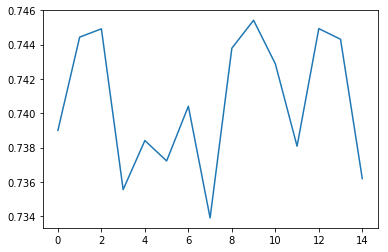

In [104]:
plt.plot(scores)